In [ ]:
import numpy as np
import io
import scipy.integrate as integrate
import scipy.special as special
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft, fftfreq
from matplotlib.font_manager import ft2font
from scipy.io import wavfile
from scipy.signal import butter, sos2zpk

#PART A

# 1. Import the raw emg data from the csv file

In [ ]:
#load the csv file into the code
raw_data = pd.read_csv('EMG_Datasets.csv')
#print the data given
raw_data

,Time (s),EMG_Relaxed (mV),EMG_Contracted (mV)
0,0.000000,0.006408,0.077323
1,0.000488,0.020228,0.090928
2,0.000977,0.024025,0.105868
3,0.001465,0.029097,0.108858
4,0.001953,0.041916,0.096336
...,...,...,...
10235,4.998047,0.062229,0.081343
10236,4.998535,0.073073,0.093125
10237,4.999023,0.081152,0.092139
10238,4.999512,0.081137,0.081911


#2. Plot the raw EMG data in the time domain

Text(0, 0.5, 'Voltage Amplitude (V)')

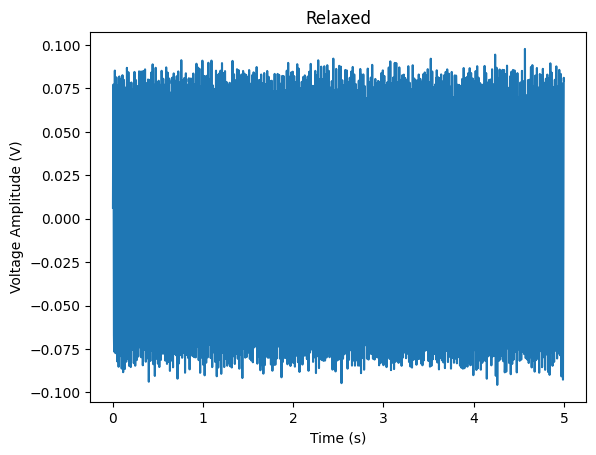

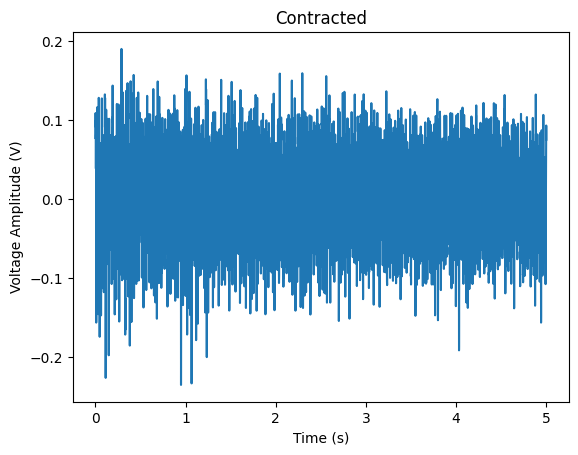

In [ ]:

data=np.array(raw_data) # Turn data type from text to numbers
time=data[:,0]
volt_relaxed=data[:,1]
volt_contracted=data[:,2]

#plot figures seperately
plt.figure(1)
plt.plot(time,volt_relaxed) # plot the first column vs the second column
plt.title("Relaxed")
plt.xlabel("Time (s)")
plt.ylabel("Voltage Amplitude (V)")

plt.figure(2)
plt.plot(time,volt_contracted) # plot the first column vs the second column
plt.title("Contracted")
plt.xlabel("Time (s)")
plt.ylabel("Voltage Amplitude (V)")

#3.1. Apply a bandstop filter to both data sets

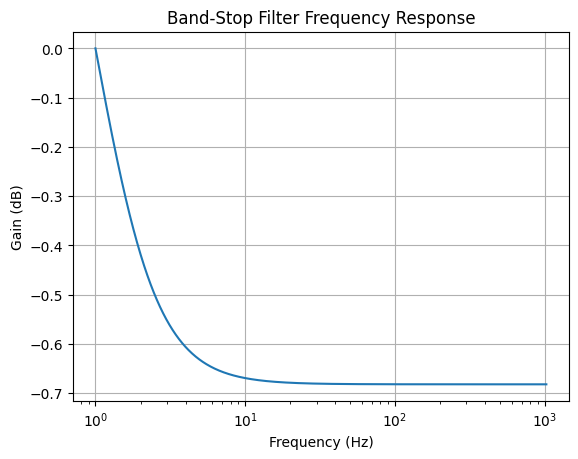

In [ ]:
#########################create the filter#################################
# order=8
# fN_L = 55
# fN_H = 65
# sos=signal.butter(order,[fN_L,fN_H], btype='bandstop', fs=2050, output='sos') # Creates the filter with type 'band'

#######################find poles of filter used###############################
# Convert the SOS filter representation to zeros, poles, and gain (zpk) representation
# z, p, k = sos2zpk(sos)
# print("Poles of the filter:", p)

# print()

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import sos2tf, freqs

order = 8
fN_L = 55
fN_H = 65
fs = 2050

# Design the band-stop filter and get the SOS representation
sos = signal.butter(order, [fN_L, fN_H], btype='bandstop', fs=fs, output='sos')

# Convert SOS to transfer function representation
numerator, denominator = sos2tf(sos)

# Define the frequency range for the frequency response plot
frequencies = np.logspace(0, np.log10(fs / 2), 1000)

# Compute the frequency response of the filter
w, h = freqs(numerator, denominator, worN=frequencies)

# Plot the frequency response
plt.figure()
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title("Band-Stop Filter Frequency Response")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.grid()
plt.show()


In [ ]:
# Given poles (complex conjugate pairs)
poles = np.array([
    0.96791353 + 0.1818065j,
    0.96945533 + 0.17609962j,
    0.96871367 + 0.18785019j,
    0.97291252 + 0.17152586j,
    0.97192127 + 0.19322896j,
    0.97767223 + 0.16859477j,
    0.97712618 + 0.19693498j,
    0.9830789 + 0.16755788j
])

# Calculate the denominator polynomial A(z)
denominator_coeffs = np.poly(poles)

# Convert the coefficients to the transfer function notation
denominator = [1.0] + list(-denominator_coeffs)  # The list is negated because poly returns the negative of the coefficients

# The numerator B(z) is a constant, as there are no zeros at the origin
numerator = [1.0]

# Display the transfer function
print("Transfer function H(z) = B(z) / A(z):")
print("Numerator (B(z)): ", numerator)
print("Denominator (A(z)): ", denominator)


Transfer function H(z) = B(z) / A(z):
Numerator (B(z)):  [1.0]
Denominator (A(z)):  [1.0, (-1-0j), (7.788793629999999+1.44359876j), (-25.629682078923324-9.83855973406039j), (46.356595765748324+28.40822137939395j), (-50.010103201057014-45.03104798954604j), (32.45285192095408+42.295631888568224j), (-11.98266961186603-23.519216409164223j), (2.1207997266171033+7.160761244185886j), (-0.09658663423145716-0.9193902487235242j)]


10240
10240


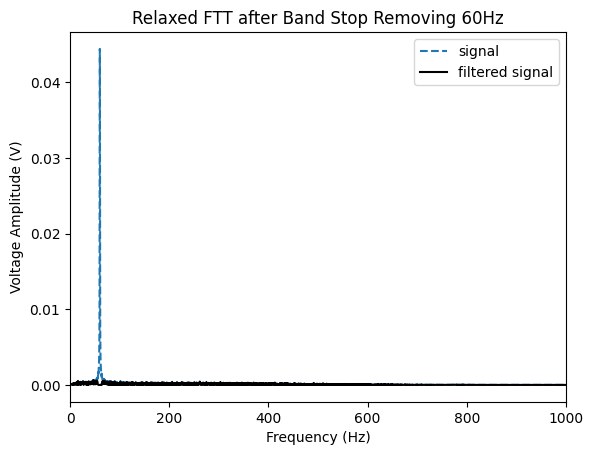

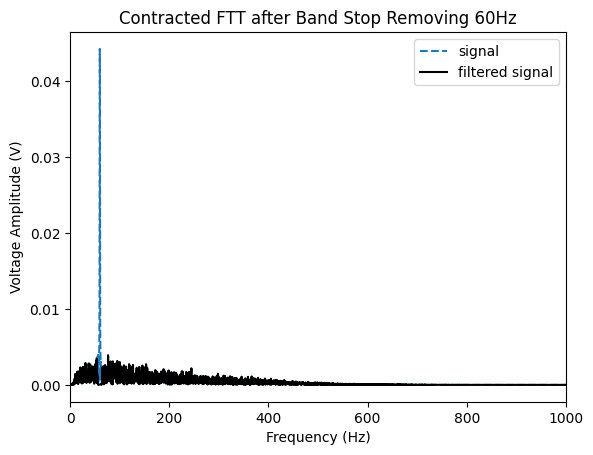

In [ ]:
x=np.linspace(0,10,20500) # fs is 20500/10 = 2050
#y=np.sin(2*np.pi*100*x) # frequency is 100 Hz
y_r= volt_relaxed
y_c = volt_contracted

################APPLY TO RELAXED DATA#################
datasbf_r = signal.sosfilt(sos,y_r) # Applies the filter

# Get the fft of both unfiltered and filtered
N=len(y_r)
print(N)
yf_r=(2/N) * np.abs(fft(y_r))
datasbf_f_r=(2/N) * np.abs(fft(datasbf_r))

# Truncate fft to RHS only
xf=fftfreq(N,1/2050) # ts=1/fs is the 0.001
yf_r=yf_r[0:N//2]
datasbf_f_r=datasbf_f_r[0:N//2]
xf=xf[0:N//2]

###############APPLY TO CONTRACTED DATA###############
datasbf_c = signal.sosfilt(sos,y_c) # Applies the filter

# Get the fft of both unfiltered and filtered
N=len(y_c)
print(N)
yf_c=(2/N) * np.abs(fft(y_c))
datasbf_f_c=(2/N) * np.abs(fft(datasbf_c))

# Truncate fft to RHS only
xf=fftfreq(N,1/2050) # ts=1/fs is the 0.001
yf_c=yf_c[0:N//2]
datasbf_f_c=datasbf_f_c[0:N//2]
xf=xf[0:N//2]

############# Plot them #################
plt.figure(1)
plt.title("Relaxed FTT after Band Stop Removing 60Hz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Voltage Amplitude (V)")
plt.plot(xf,yf_r,'--',label='signal')
plt.plot(xf,datasbf_f_r,'k',label='filtered signal')
plt.xlim([0,1000])
plt.legend()

plt.figure(2)
plt.title("Contracted FTT after Band Stop Removing 60Hz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Voltage Amplitude (V)")
plt.plot(xf,yf_c,'--',label='signal')
plt.plot(xf,datasbf_f_c,'k',label='filtered signal')
plt.xlim([0,1000])
plt.legend()


#3.2. Zoom in on y-axis

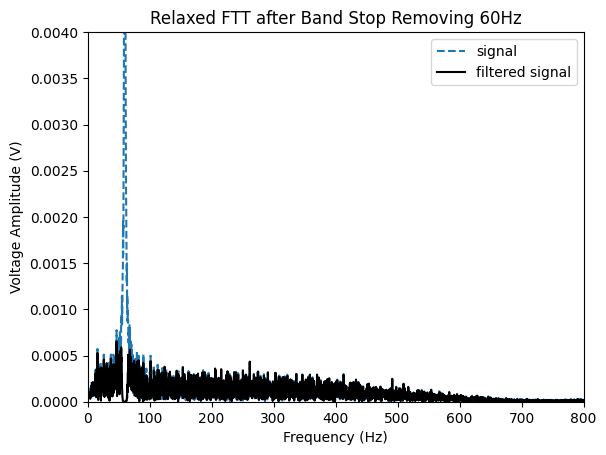

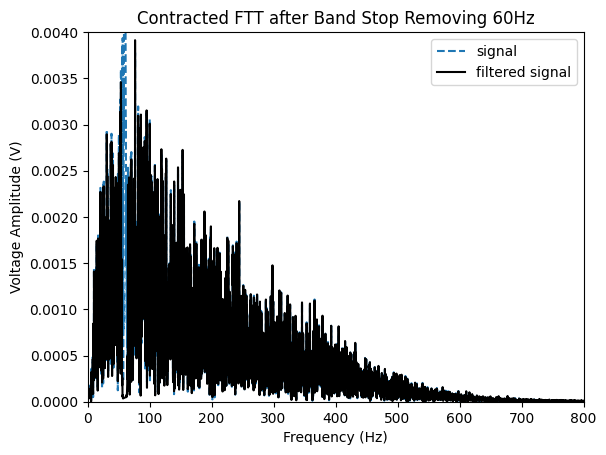

In [ ]:
############# Plot them #################
plt.figure(1)
plt.title("Relaxed FTT after Band Stop Removing 60Hz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Voltage Amplitude (V)")
plt.plot(xf,yf_r,'--',label='signal')
plt.plot(xf,datasbf_f_r,'k',label='filtered signal')
plt.xlim([0,800])
plt.ylim([0,0.004])
plt.legend()

plt.figure(2)
plt.title("Contracted FTT after Band Stop Removing 60Hz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Voltage Amplitude (V)")
plt.plot(xf,yf_c,'--',label='signal')
plt.plot(xf,datasbf_f_c,'k',label='filtered signal')
plt.xlim([0,800])
plt.ylim([0,0.004])
plt.legend()

#3.3. Zoom on on both axes

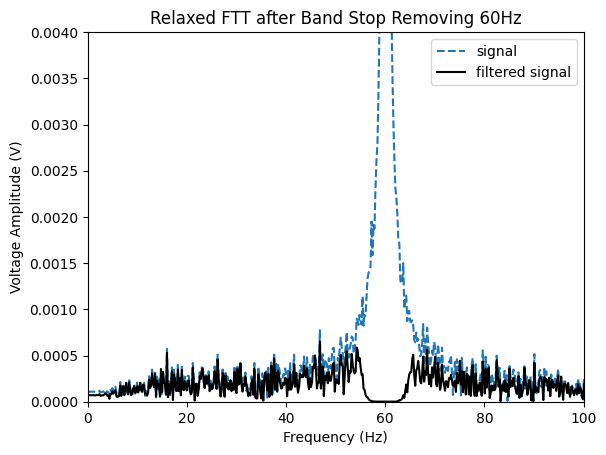

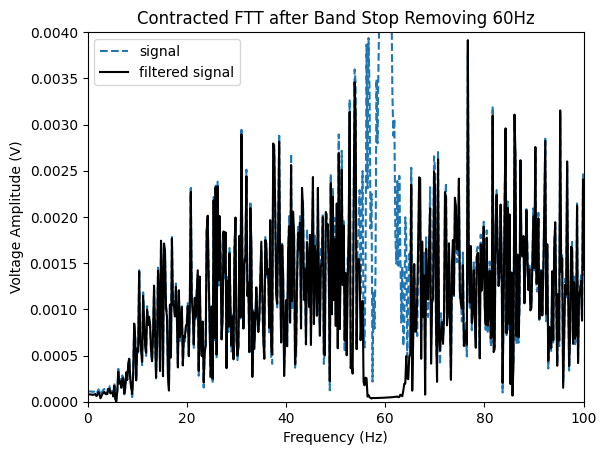

In [ ]:
############# Plot them #################
plt.figure(1)
plt.title("Relaxed FTT after Band Stop Removing 60Hz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Voltage Amplitude (V)")
plt.plot(xf,yf_r,'--',label='signal')
plt.plot(xf,datasbf_f_r,'k',label='filtered signal')
plt.xlim([0,100])
plt.ylim([0,0.004])
plt.legend()

plt.figure(2)
plt.title("Contracted FTT after Band Stop Removing 60Hz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Voltage Amplitude (V)")
plt.plot(xf,yf_c,'--',label='signal')
plt.plot(xf,datasbf_f_c,'k',label='filtered signal')
plt.xlim([0,100])
plt.ylim([0,0.004])
plt.legend()

#4.1. Apply a bandpass filter to both EMG datasets

In [ ]:
order=8
fB_L = 0.1
fB_H = 450

sos=signal.butter(order,[fB_L, fB_H], btype='bandpass', fs=2050, output='sos') # Creates the filter with type 'band'

#######################find poles of filter used###############################
# Convert the SOS filter representation to zeros, poles, and gain (zpk) representation
z, p, k = sos2zpk(sos)
print("Poles of the filter:", p)

print()

# Given poles (complex conjugate pairs)
poles = np.array([
    0.09717703+0.0976057683j,
      0.10496993+0.300376257j,
 0.1232816+0.528285622j,
 0.15980887+0.808136151j,
 0.99969933+0.0000598193700j,
 0.99974514+0.000170324652j,
 0.99982973+0.000254857879j,
 0.99994018+0.000300598121j
])

# Calculate the denominator polynomial A(z)
denominator_coeffs = np.poly(poles)

# Convert the coefficients to the transfer function notation
denominator = [1.0] + list(-denominator_coeffs)  # The list is negated because poly returns the negative of the coefficients

# The numerator B(z) is a constant, as there are no zeros at the origin
numerator = [1.0]

# Display the transfer function
print("Transfer function H(z) = B(z) / A(z):")
print("Numerator (B(z)): ", numerator)
print("Denominator (A(z)): ", denominator)

Poles of the filter: [0.09717703+9.76057683e-02j 0.09717703-9.76057683e-02j
 0.10496993+3.00376257e-01j 0.10496993-3.00376257e-01j
 0.1232816 +5.28285622e-01j 0.1232816 -5.28285622e-01j
 0.15980887+8.08136151e-01j 0.15980887-8.08136151e-01j
 0.99969933+5.98193700e-05j 0.99969933-5.98193700e-05j
 0.99974514+1.70324652e-04j 0.99974514-1.70324652e-04j
 0.99982973+2.54857879e-04j 0.99982973-2.54857879e-04j
 0.99994018+3.00598121e-04j 0.99994018-3.00598121e-04j]

Transfer function H(z) = B(z) / A(z):
Numerator (B(z)):  [1.0]
Denominator (A(z)):  [1.0, (-1-0j), (4.48445181+1.7351893983220001j), (-7.035860128842087-7.545297025567337j), (3.0864294743713603+12.690629491525863j), (3.3242339483876395-9.993116055773745j), (-4.398912046711538+3.241138454793664j), (1.75145212765978+0.06946398849327372j), (-0.2112531774780445-0.21757021083902509j), (-0.0005420073871128612+0.01956195904529657j)]


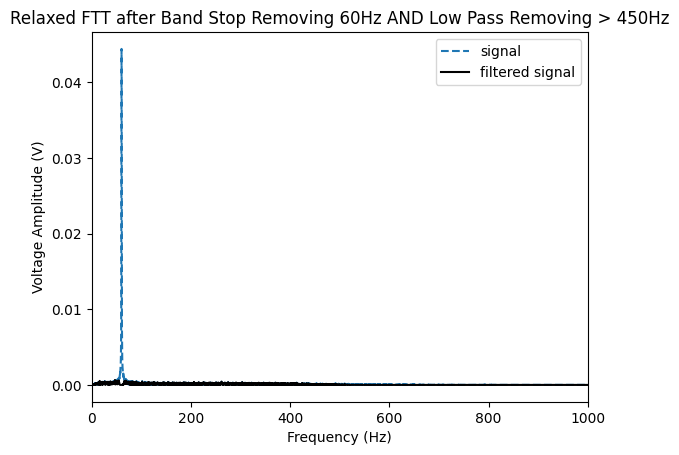

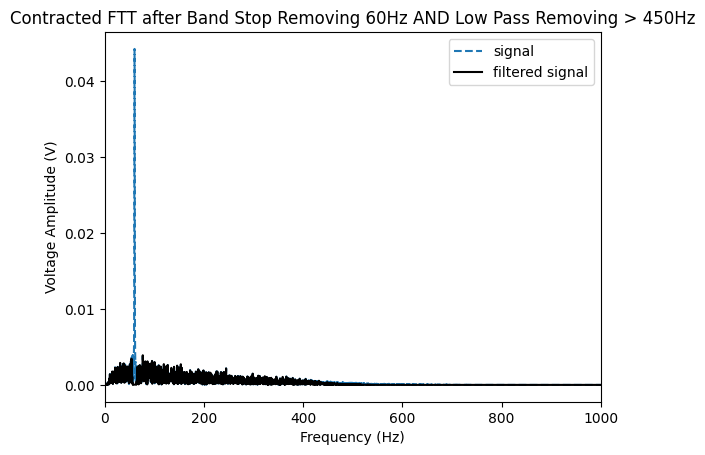

In [ ]:
################APPLY TO RELAXED DATA#################
datalpf_r = signal.sosfilt(sos,datasbf_r) # Applies the filter

# Get the fft of both unfiltered and filtered

datalpf_f_r=(2/N) * np.abs(fft(datalpf_r))

# Truncate fft to RHS only
xf=fftfreq(N,1/2050) # ts=1/fs is the 0.001
yf_r=yf_r[0:N//2]
datalpf_f_r=datalpf_f_r[0:N//2]
xf=xf[0:N//2]

################APPLY TO CONTRACTED  DATA#################
datalpf_c = signal.sosfilt(sos,datasbf_c) # Applies the filter

# Get the fft of both unfiltered and filtered

datalpf_f_c=(2/N) * np.abs(fft(datalpf_c))

# Truncate fft to RHS only
xf=fftfreq(N,1/2050) # ts=1/fs is the 0.001
yf_c=yf_c[0:N//2]
datalpf_f_c=datalpf_f_c[0:N//2]
xf=xf[0:N//2]

################ Plot them #################
plt.figure(1)
plt.title("Relaxed FTT after Band Stop Removing 60Hz AND Low Pass Removing > 450Hz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Voltage Amplitude (V)")
plt.plot(xf,yf_r,'--',label='signal')
plt.plot(xf,datalpf_f_r,'k',label='filtered signal')
plt.xlim([0,1000])
plt.legend()

plt.figure(2)
plt.title("Contracted FTT after Band Stop Removing 60Hz AND Low Pass Removing > 450Hz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Voltage Amplitude (V)")
plt.plot(xf,yf_c,'--',label='signal')
plt.plot(xf,datalpf_f_c,'k',label='filtered signal')
plt.xlim([0,1000])
plt.legend()

#4.2. Zoom in on y-axis


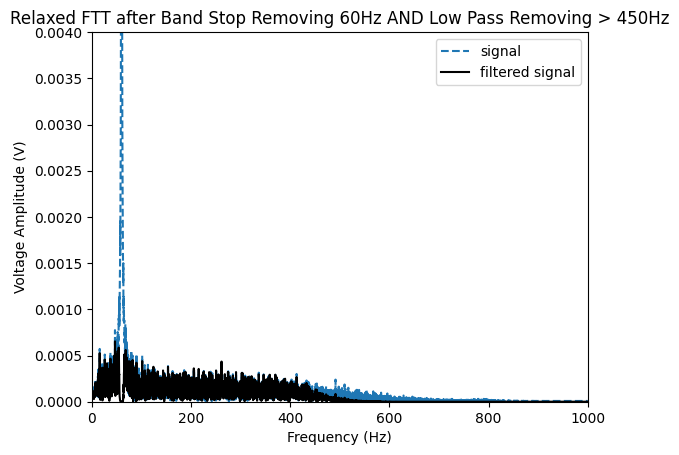

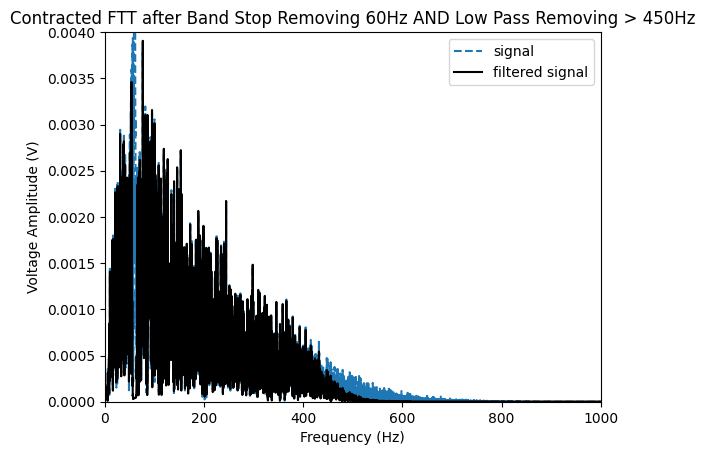

In [ ]:
################ Plot them #################
plt.figure(1)
plt.title("Relaxed FTT after Band Stop Removing 60Hz AND Low Pass Removing > 450Hz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Voltage Amplitude (V)")
plt.plot(xf,yf_r,'--',label='signal')
plt.plot(xf,datalpf_f_r,'k',label='filtered signal')
plt.xlim([0,1000])
plt.ylim([0,0.004])
plt.legend()

plt.figure(2)
plt.title("Contracted FTT after Band Stop Removing 60Hz AND Low Pass Removing > 450Hz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Voltage Amplitude (V)")
plt.plot(xf,yf_c,'--',label='signal')
plt.plot(xf,datalpf_f_c,'k',label='filtered signal')
plt.xlim([0,1000])
plt.ylim([0,0.004])
plt.legend()

#4.3. Zoom in on both axes - low end

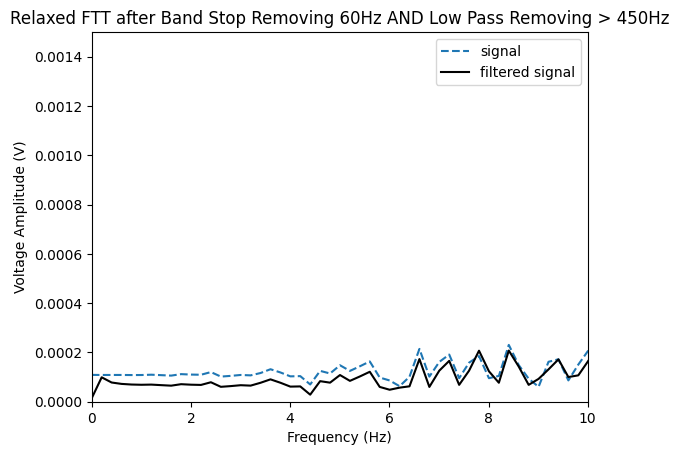

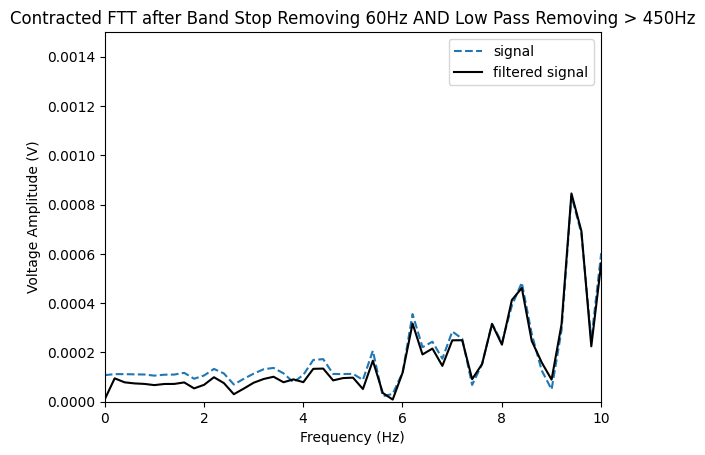

In [ ]:
################ Plot them #################
plt.figure(1)
plt.title("Relaxed FTT after Band Stop Removing 60Hz AND Low Pass Removing > 450Hz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Voltage Amplitude (V)")
plt.plot(xf,yf_r,'--',label='signal')
plt.plot(xf,datalpf_f_r,'k',label='filtered signal')
plt.xlim([0,10])
plt.ylim([0,0.0015])
plt.legend()

plt.figure(2)
plt.title("Contracted FTT after Band Stop Removing 60Hz AND Low Pass Removing > 450Hz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Voltage Amplitude (V)")
plt.plot(xf,yf_c,'--',label='signal')
plt.plot(xf,datalpf_f_c,'k',label='filtered signal')
plt.xlim([0,10])
plt.ylim([0,0.0015])
plt.legend()

#4.4. Zoom in on both axes - high end

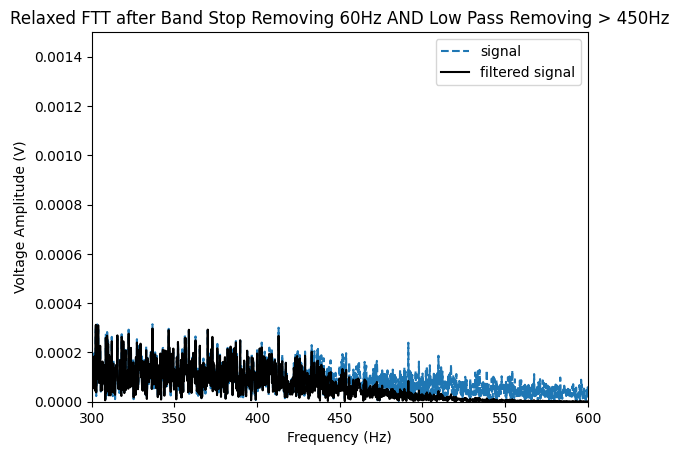

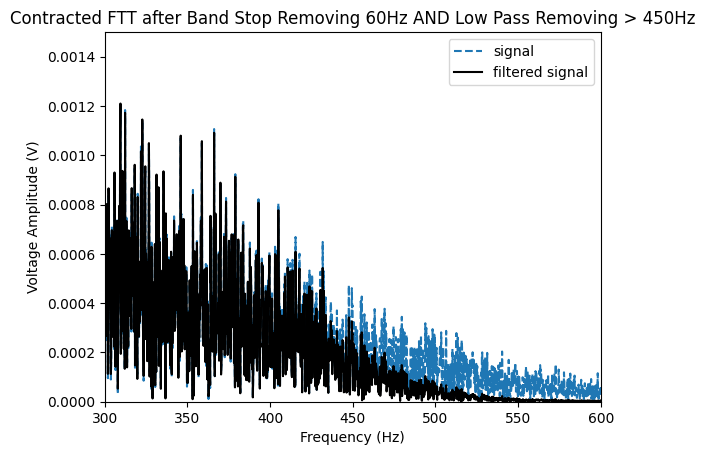

In [ ]:
################ Plot them #################
plt.figure(1)
plt.title("Relaxed FTT after Band Stop Removing 60Hz AND Low Pass Removing > 450Hz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Voltage Amplitude (V)")
plt.plot(xf,yf_r,'--',label='signal')
plt.plot(xf,datalpf_f_r,'k',label='filtered signal')
plt.xlim([300,600])
plt.ylim([0,0.0015])
plt.legend()

plt.figure(2)
plt.title("Contracted FTT after Band Stop Removing 60Hz AND Low Pass Removing > 450Hz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Voltage Amplitude (V)")
plt.plot(xf,yf_c,'--',label='signal')
plt.plot(xf,datalpf_f_c,'k',label='filtered signal')
plt.xlim([300,600])
plt.ylim([0,0.0015])
plt.legend()

#5. Filtered vs Unfiltered EMG data in the time domain

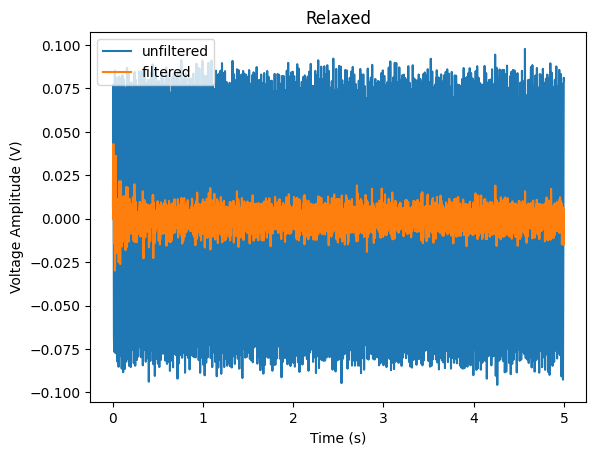

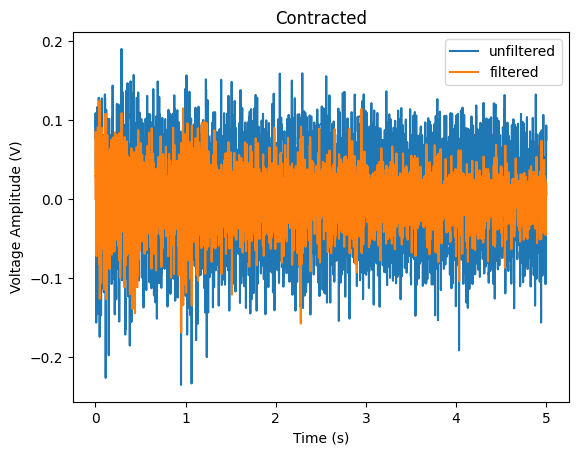

In [ ]:
plt.figure(1)
plt.plot(time,volt_relaxed, label = "unfiltered")
plt.plot(time,datalpf_r, label = "filtered") # plot the first column vs the second column
plt.title("Relaxed")
plt.xlabel("Time (s)")
plt.ylabel("Voltage Amplitude (V)")
plt.legend()

plt.figure(2)
plt.plot(time,volt_contracted, label = "unfiltered")
plt.plot(time,datalpf_c, label = "filtered") # plot the first column vs the second column
plt.title("Contracted")
plt.xlabel("Time (s)")
plt.ylabel("Voltage Amplitude (V)")
plt.legend()



## 6. Calcuated RMS Values for Filtered, Unfiltered, Relaxed, and Contracted Data and Determine if contracted or not

In [ ]:
#calculate the rms values for signals before each filter, after the stopband filter and after both filters
rms_r_nf = round(np.sqrt(np.mean(volt_relaxed**2)), 4)
print("1. Relaxed & no filter: RMS = " + str(rms_r_nf))

rms_r_sf = round(np.sqrt(np.mean(datasbf_r**2)), 4)
print("2. Relaxed & stop band filter: RMS = " + str(rms_r_sf))

rms_r_bf = round(np.sqrt(np.mean(datalpf_r**2)), 4)
print("3. Relaxed & both filters: RMS = " + str(rms_r_bf))

rms_c_nf = round(np.sqrt(np.mean(volt_contracted**2)), 4)
print("4. Contracted & no filter: RMS = " + str(rms_c_nf))

rms_c_sf = round(np.sqrt(np.mean(datasbf_c**2)), 4)
print("5. Contracted & stop band filter: RMS = " + str(rms_c_sf))

rms_c_bf = round(np.sqrt(np.mean(datalpf_c**2)), 4)
print("6. Contracted & both filters: RMS = " + str(rms_c_bf))
print()

#algorithm to determine if the muscle is contracted or not
thres = 0.02
inx = 1

emg_data = [rms_r_nf, rms_r_sf, rms_r_bf, rms_c_nf, rms_c_sf, rms_c_bf]

for rms in emg_data:
  if rms > thres:
    print(str(inx) + "--> contracted" )
  else:
    print(str(inx) + "--> relaxed" )
  inx = inx + 1

1. Relaxed & no filter: RMS = 0.0568
2. Relaxed & stop band filter: RMS = 0.0058
3. Relaxed & both filters: RMS = 0.0056
4. Contracted & no filter: RMS = 0.0645
5. Contracted & stop band filter: RMS = 0.0306
6. Contracted & both filters: RMS = 0.0305

1--> contracted
2--> relaxed
3--> relaxed
4--> contracted
5--> contracted
6--> contracted


In [ ]:
# Create a DataFrame from the data
df = pd.DataFrame({'Time': time, 'Filtered EMG_Relaxed (mV)': datalpf_r, 'Filtered EMG_Contracted (mV)': datalpf_c})

# Specify the filename and save the DataFrame to a CSV file
filename = 'output.csv'
df.to_csv(filename, index=False)

